In [1]:
%pylab inline
%load_ext autotime
%load_ext autoreload
%autoreload 2
import scanpy as sc

from pysctransform.pysctransform import vst
from pysctransform.plotting import plot_fit, plot_residual_var, compare_with_sct


Populating the interactive namespace from numpy and matplotlib
time: 16.5 s (started: 2021-02-26 01:33:42 -05:00)


In [2]:
pbmc33k = sc.read_h5ad("../data/pbmc33k.h5ad")
pbmc3k = sc.read_h5ad("../data/pbmc3k.h5ad")

time: 1.06 s (started: 2021-02-26 01:33:59 -05:00)


# PBMC3k

Running Step1


100%|██████████| 2000/2000 [00:48<00:00, 41.51it/s]


Step1 done. Took 49.0 seconds.
Running Step2
Step2 done. Took 6.0 seconds.
Running Step3
Step3 done. Took 2.0 seconds.


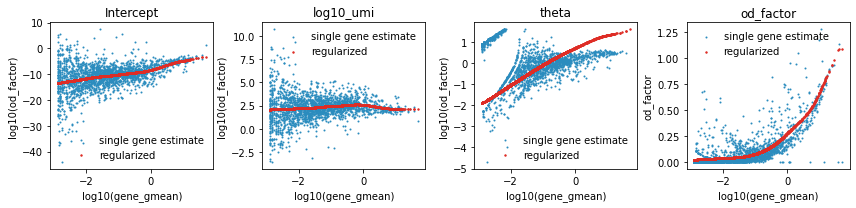

time: 59.3 s (started: 2021-02-26 01:34:00 -05:00)


In [3]:
# Input is gene x cell
vst_out_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    fit_type="theta_ml",
)
_ = plot_fit(vst_out_3k)


<AxesSubplot:xlabel='Residual variance'>

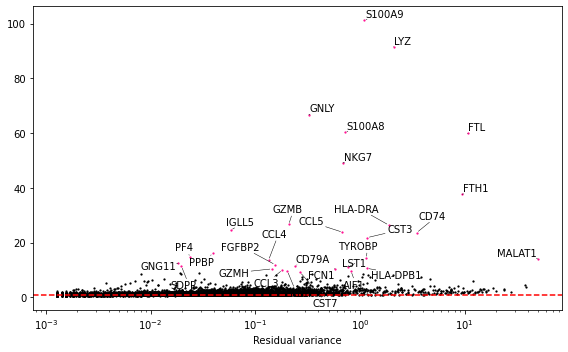

time: 22.8 s (started: 2021-02-26 01:34:59 -05:00)


In [4]:
plot_residual_var(vst_out_3k)

## Compare model parameters to R SCTransform

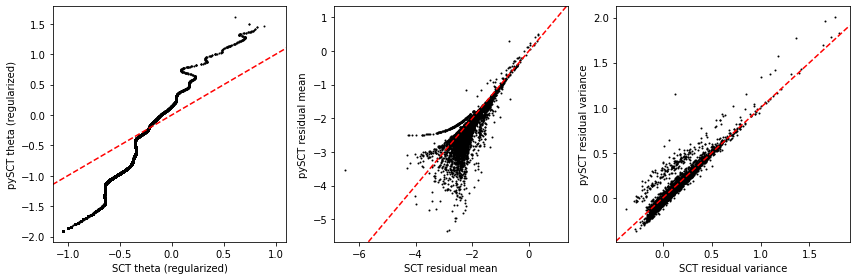

time: 462 ms (started: 2021-02-26 01:35:22 -05:00)


In [5]:
compare_with_sct(vst_out_3k, 
                 sct_modelparsfit_file="~/data/pbmc3k/pbmc3k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc3k/pbmc3k_thetaml_gene_attr.csv"
                )

# PBMC33k

Running Step1


100%|██████████| 2000/2000 [01:14<00:00, 26.73it/s]


Step1 done. Took 77.0 seconds.
Running Step2
Step2 done. Took 7.0 seconds.
Running Step3
Step3 done. Took 18.0 seconds.


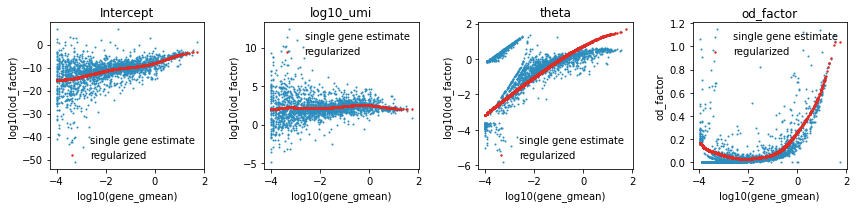

time: 1min 58s (started: 2021-02-26 01:35:22 -05:00)


In [6]:
# Input is gene x cell
vst_out_33k = vst(
    pbmc33k.X.T,
    gene_names=pbmc33k.var_names.tolist(),
    cell_names=pbmc33k.obs_names.tolist(),
    fit_type="theta_ml",
)
_ = plot_fit(vst_out_33k)


<AxesSubplot:xlabel='Residual variance'>

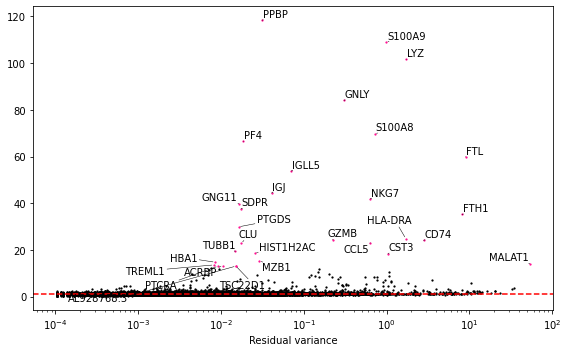

time: 4.92 s (started: 2021-02-26 01:37:21 -05:00)


In [7]:
plot_residual_var(vst_out_33k)

## Compare model parameters to R SCTransform

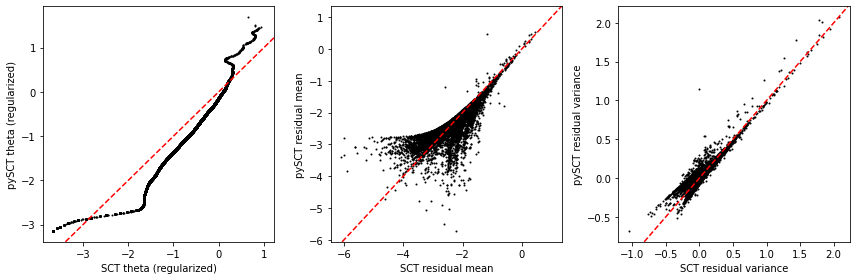

time: 565 ms (started: 2021-02-26 01:37:26 -05:00)


In [8]:
compare_with_sct(vst_out_33k, 
                 sct_modelparsfit_file="~/data/pbmc33k/pbmc33k_thetaml_model_pars_fit.csv",
                 sct_geneattr_file="~/data/pbmc33k/pbmc33k_thetaml_gene_attr.csv"
                )